In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K

In [2]:
data_in = np.load("a2_data/images.npy")
data_out = np.load("a2_data/labels.npy")

In [3]:
def convert_to_num(hour, minute):
    num = hour+minute/60
    return num

def clock_loss_reg_mse(y_true, y_pred):
    absdiff = K.abs(y_pred - y_true)
    norm_c = absdiff <= 6
    norm_c = tf.cast(norm_c, tf.float32)
    round_c = absdiff > 6
    round_c = tf.cast(round_c, tf.float32)
    normdiff = K.abs(y_pred - y_true)
    rounddiff = 12 - K.abs((y_pred - y_true))
    
    diff = norm_c * normdiff + round_c * rounddiff
    mse = K.mean(diff)
    return mse

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [4]:
data_in, data_out = unison_shuffled_copies(data_in, data_out)

In [5]:
reg_out = []
for i in range(len(data_out)):
    hour = data_out[i][0]
    minute = data_out[i][1]
    hr_min_num = convert_to_num(hour, minute)
    reg_out.append(hr_min_num)
reg_out = np.array(reg_out)

In [6]:
X_valid, X_train = data_in[15000:]/np.amax(data_in), data_in[:15000]/np.amax(data_in)
y_valid, y_train = reg_out[15000:], reg_out[:15000]

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=(5,5), strides=1, 
                        activation='relu', input_shape=[150,150,1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(128, kernel_size=(3,3), strides=1, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(256, kernel_size=(3,3), strides=1, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(512, kernel_size=(3,3), strides=1, activation='relu'),
    #keras.layers.MaxPooling2D(pool_size=(2,2)),
    #keras.layers.Conv2D(640, kernel_size=2, strides=1, activation='relu'),
    #keras.layers.MaxPooling2D(pool_size=(2,2)),
    #keras.layers.Conv2D(768, kernel_size=2, strides=1, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

Metal device set to: Apple M1


2022-11-11 21:42:15.080989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-11 21:42:15.081071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
'''
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', 
                        input_shape=[150,150,1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4)
])
'''

"\nmodel = keras.models.Sequential([\n    keras.layers.Conv2D(64, 7, activation='relu', padding='same', \n                        input_shape=[150,150,1]),\n    keras.layers.MaxPooling2D(2),\n    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),\n    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),\n    keras.layers.MaxPooling2D(2),\n    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),\n    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),\n    keras.layers.MaxPooling2D(2),\n    keras.layers.Flatten(),\n    keras.layers.Dense(128, activation='relu'),\n    keras.layers.Dropout(0.5),\n    keras.layers.Dense(64, activation='relu'),\n    keras.layers.Dropout(0.5),\n    keras.layers.Dense(4)\n])\n"

In [9]:
opt = keras.optimizers.SGD(learning_rate=0.001)

In [10]:
model.compile(loss='mse', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=50,
                   validation_data=(X_valid, y_valid))

Epoch 1/50


2022-11-11 21:42:15.898135: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-11 21:42:16.258177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 673.7145 - accuracy: 0.0014

2022-11-11 21:45:09.974674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 183s 389ms/step - loss: 673.7145 - accuracy: 0.0014 - val_loss: 12.1422 - val_accuracy: 0.0013
Epoch 2/50
469/469 [==============================] - 182s 388ms/step - loss: 12.5332 - accuracy: 0.0014 - val_loss: 13.0802 - val_accuracy: 0.0013
Epoch 3/50
469/469 [==============================] - 182s 388ms/step - loss: 12.2913 - accuracy: 0.0014 - val_loss: 10.8896 - val_accuracy: 0.0013
Epoch 4/50
469/469 [==============================] - 182s 389ms/step - loss: 10.1708 - accuracy: 0.0014 - val_loss: 9.1763 - val_accuracy: 0.0013
Epoch 5/50
469/469 [==============================] - 182s 389ms/step - loss: 8.4754 - accuracy: 0.0014 - val_loss: 7.4317 - val_accuracy: 0.0013
Epoch 6/50
469/469 [==============================] - 187s 399ms/step - loss: 6.7333 - accuracy: 0.0014 - val_loss: 6.1977 - val_accuracy: 0.0013
Epoch 7/50
469/469 [==============================] - 192s 409ms/step - loss: 5.2287 - accuracy: 0.0013 - val_loss: 4.9847 - va

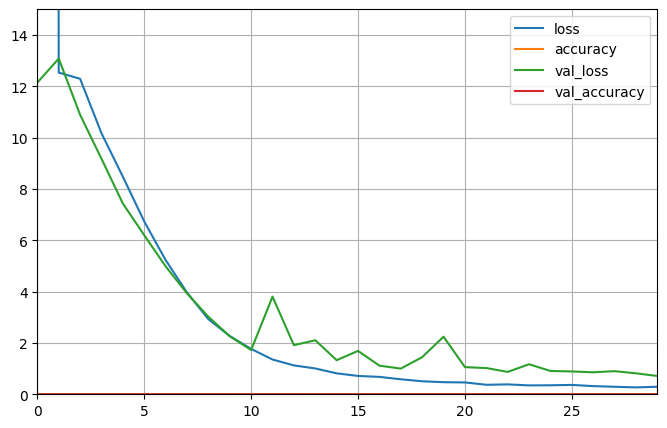

In [16]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,15) # set the vertical range to [0-1]
plt.gca().set_xlim(0,29)
plt.show()